In [1]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [10]:
df = pd.read_excel('/media/gagandeep/2E92405C92402AA3/Work/Codes/PythonCodes/Mood-Based-Song-Recommendation-System/Analysis/metadata.xlsx')
df.head()


,Emotion,Dataset_Link,Dataset_Type
0,anger,http://saifmohammad.com/WebDocs/EmoInt%20Train...,Train
1,fear,http://saifmohammad.com/WebDocs/EmoInt%20Train...,Train
2,joy,http://saifmohammad.com/WebDocs/EmoInt%20Train...,Train
3,sadness,http://saifmohammad.com/WebDocs/EmoInt%20Train...,Train
4,anger,http://saifmohammad.com/WebDocs/EmoInt%20Test%...,Test


In [11]:
# Prepare Train data
df_to_concat = []
for link in df['Dataset_Link']:
    temp_df = pd.read_csv(link, sep='\t', error_bad_lines=False, header=None)
    df_to_concat.append(temp_df)

data = pd.concat(df_to_concat)
data.columns = ['idx', 'text', 'label', 'label_inten']
data = data.drop(['idx', 'label_inten'], axis=1)

In [12]:
data.tail()

,text,label
668,Why does Candice constantly pout #GBBO 💄😒,sadness
669,"@redBus_in #unhappy with #redbus CC, when I ta...",sadness
670,"@AceOperative789 no pull him afew weeks ago, s...",sadness
671,I'm buying art supplies and I'm debating how s...,sadness
672,@sainsburys Could you ask your Chafford Hundre...,sadness


In [13]:
data.shape

(6755, 2)

In [14]:
data['label'].value_counts()

fear       2142
anger      1617
joy        1537
sadness    1459
Name: label, dtype: int64

In [21]:
label_dict = dict(enumerate(list(data['label'].unique())))
label_dict

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness'}

In [22]:
y = pd.get_dummies(data['label'])
labels = y.columns
y = y.values

In [23]:
import pickle
with open('labels.pkl', 'wb') as p:
    pickle.dump(label_dict, p)


In [73]:
import re
def remove_usernames(x):
    pat = '@[^\s]+'
    return re.sub(pat, '', x)

In [74]:
data['text'] = data['text'].str.lower().apply(remove_usernames)

In [75]:
def remove_punctuation(x):
    pat = '[!#?,.:";]'
    return re.sub(pat, '', x)

In [76]:
data['text'] = data['text'].apply(remove_punctuation)

In [77]:
def remove_emojis(x):
    pat = re.compile(pattern = "["
      u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return pat.sub(r'',x )


In [78]:
data['text'] = data['text'].str.replace("\\", "").apply(remove_emojis)

In [79]:
data['text'] = data['text'].str.replace("&amp", "")

In [80]:
word_list = []
# Find Unique words
def get_unique_words(x, word_list=word_list):
    for word in x.split():
        if word not in word_list:
            word_list.append(word)

In [81]:
data['text'].apply(lambda x: get_unique_words(x))
len(word_list)

13798

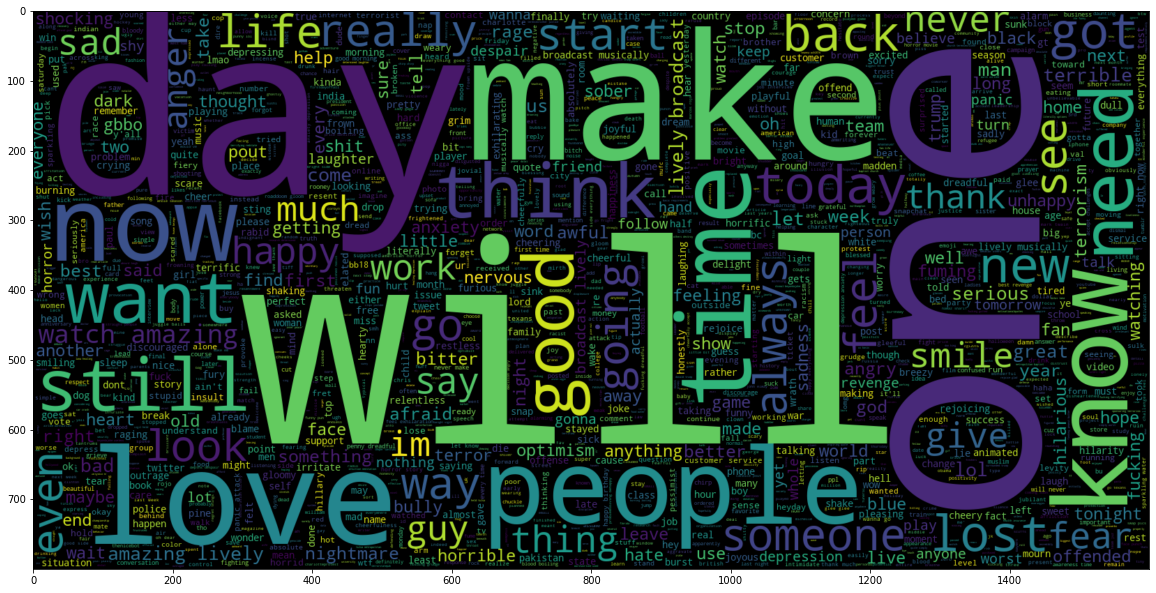

In [122]:
# WORD CLOUD
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000, width = 1600, height = 800 ).generate(" ".join(data.text))
plt.imshow(wc, interpolation = 'bilinear')

In [82]:
# TOKENIZATION
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.tokenize import word_tokenize

In [83]:
import heapq
tokenized_text = []
for doc in data.text:
    heapq.heappush(tokenized_text, len(word_tokenize(doc)))

In [84]:
maxlen = heapq.nlargest(1,tokenized_text)[0] + 5
max_features = 5000


In [85]:
def tokenize_pad(x):
    tokenizer = Tokenizer(max_features)
    tokenizer.fit_on_texts(x)
    sequences = tokenizer.texts_to_sequences(x)
    padded = pad_sequences(sequences=sequences, maxlen=maxlen, padding='post')
    return tokenizer, sequences, padded

In [86]:
x_tokenizer, x_sequences, x_padded = tokenize_pad(data['text'])

In [87]:
import pickle
with open('tokenizer.pkl', 'wb') as p:
    pickle.dump(x_tokenizer,p)
with open('sequences.pkl', 'wb') as p:
    pickle.dump(x_sequences,p)
with open('padded.pkl', 'wb') as p:
    pickle.dump(x_padded,p)


In [88]:
vocab_size = len(word_list) + 1

In [191]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-08-17 00:12:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)...171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80...connected.
HTTP request sent, awaiting response...302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-17 00:12:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443...connected.
HTTP request sent, awaiting response...301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-17 00:12:51--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)...171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80...connected.
HTTP request sent, awaiting response...200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip   

In [192]:
!unzip -q glove.6B.zip

In [89]:
import tqdm
import numpy as np
# Embedding
embedding_dim = 100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in tqdm.tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

400000it [00:13, 29645.34it/s]


In [90]:
# Embedding Matrix
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in tqdm.tqdm(x_tokenizer.word_index.items()):
    if index > max_features - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

38%|███▊      | 4999/13326 [00:00<00:00, 258479.32it/s]


In [91]:
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D 
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers

In [92]:
embedding_matrix.shape

(5000, 100)

In [96]:
filters = 250
kernel_size = 3
hidden_dims = 256

In [102]:
model = Sequential()
model.add(Embedding(max_features, 
        embedding_dim, 
        embeddings_initializer = initializers.Constant(embedding_matrix),trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(filters, kernel_size, padding='valid'))
model.add(MaxPooling1D())
model.add(Conv1D(filters, 5, padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(LSTM(hidden_dims, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 250)         0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 250)         312750    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 250)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 250)        

In [103]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
X_train, X_test, y_train, y_test = train_test_split(x_padded, y, test_size=0.1, stratify=y)

In [107]:
model.fit(x_padded, y, batch_size=32, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
212/212 [==============================] - 14s 67ms/step - loss: 1.1986 - accuracy: 0.4527 - val_loss: 0.8355 - val_accuracy: 0.6701
Epoch 2/25
212/212 [==============================] - 13s 62ms/step - loss: 0.7944 - accuracy: 0.6868 - val_loss: 0.5389 - val_accuracy: 0.7840
Epoch 3/25
212/212 [==============================] - 13s 62ms/step - loss: 0.6346 - accuracy: 0.7519 - val_loss: 0.4943 - val_accuracy: 0.8314
Epoch 4/25
212/212 [==============================] - 13s 63ms/step - loss: 0.5425 - accuracy: 0.7917 - val_loss: 0.3457 - val_accuracy: 0.8905
Epoch 5/25
212/212 [==============================] - 13s 62ms/step - loss: 0.4901 - accuracy: 0.8093 - val_loss: 0.3138 - val_accuracy: 0.8683
Epoch 6/25
212/212 [==============================] - 13s 63ms/step - loss: 0.4250 - accuracy: 0.8389 - val_loss: 0.2687 - val_accuracy: 0.8994
Epoch 7/25
212/212 [==============================] - 14s 64ms/step - loss: 0.3985 - accuracy: 0.8480 - val_loss: 0.1992 - val_accuracy:

In [108]:
model.save('Glove_embedding_CNN_LSTM_model.h5')

In [ ]:
def prepare_data(x):
    

In [ ]:
def remove_usernames(x):
    pat = '@[^\s]+'
    return re.sub(pat, '', x)

In [132]:
label_dict[model.predict_classes(x_padded[1000].reshape(-1,41))[0]]


'fear'

In [126]:
label_dict = dict(enumerate(labels))

In [127]:
label_dict

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness'}

In [ ]:
http://millionsongdataset.com/sites/default/files/lastfm/tracks_with_tag.txt